In [1]:
import torch
import torch_geometric
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

In [3]:
data = dataset[0]
print("shapes of list of edges, list of nodes w/ features and of class to predict")
print(data)
print("data is undirected?", data.is_undirected())
print("data has self loops?", data.contains_self_loops())

shapes of list of edges, list of nodes w/ features and of class to predict
Data(edge_index=[2, 168], x=[37, 3], y=[1])
data is undirected? True
data has self loops? False


In [ ]:
import networkx as nx
import torch_geometric
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g)

In [5]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

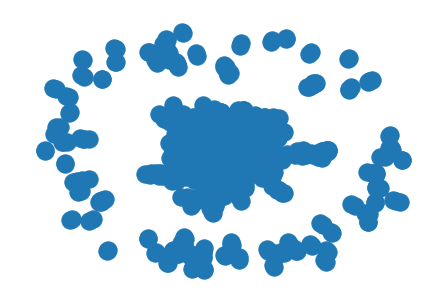

In [6]:
import networkx as nx
import torch_geometric
g = torch_geometric.utils.to_networkx(dataset[0], to_undirected=True)
nx.draw(g)

In [4]:
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import SinglePointLmdbDataset, TrajectoryLmdbDataset
import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
import matplotlib.pyplot as plt
import lmdb
import pickle
from tqdm import tqdm
import torch
import os

In [105]:
# dataset at D:\is2res_train_val_test_lmdbs\data\is2re\10k\train

dataset = SinglePointLmdbDataset({"src": "D:\\is2res_train_val_test_lmdbs\\data\\is2re\\10k\\train\\data.lmdb"})
print(len(dataset))

10000


In [106]:
print(dataset[0])

Data(atomic_numbers=[86], cell=[1, 3, 3], cell_offsets=[2964, 3], distances=[2964], edge_index=[2, 2964], fixed=[86], force=[86, 3], natoms=86, pos=[86, 3], pos_relaxed=[86, 3], sid=2472718, tags=[86], y_init=6.282500615000004, y_relaxed=-0.025550085000020317)


In [ ]:
from mpl_toolkits import mplot3d
import numpy as np

#print(dataset[0].pos)
x = dataset[0].pos[:,0]
y = dataset[0].pos[:,1]
z = dataset[0].pos[:,2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z)
 
# show plot
plt.show()

In [7]:
symbols = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Uut", "Fl", "Uup", "Lv", "Uus", "Uuo"]

In [12]:
from ase.io import read
from ase.visualize import view

i = 0
print(dataset[i])

x = dataset[i].pos[:,0]
y = dataset[i].pos[:,1]
z = dataset[i].pos[:,2]
atom = dataset[i].atomic_numbers

f = open("adsPicture.xyz", "w")
f.write(str(len(atom))+"\n")
for i in range(len(atom)):
    f.write("\n{}\t {}\t {}\t {}".format(symbols[int(atom[i])-1],x[i],y[i],z[i]))
f.close()


pic = read("adsPicture.xyz")
view(pic)

Data(atomic_numbers=[86], cell=[1, 3, 3], cell_offsets=[2964, 3], distances=[2964], edge_index=[2, 2964], fixed=[86], force=[86, 3], natoms=86, pos=[86, 3], pos_relaxed=[86, 3], sid=2472718, tags=[86], y_init=6.282500615000004, y_relaxed=-0.025550085000020317)


In [8]:
print(dataset[0])

Data(atomic_numbers=[86], cell=[1, 3, 3], cell_offsets=[2964, 3], distances=[2964], edge_index=[2, 2964], fixed=[86], force=[86, 3], natoms=86, pos=[86, 3], pos_relaxed=[86, 3], sid=2472718, tags=[86], y_init=6.282500615000004, y_relaxed=-0.025550085000020317)


In [127]:
from torch_geometric.data import DataLoader
print(len(dataset))
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

10000


In [128]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 3)

    def forward(self, data):
        x, edge_index = data.pos, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [206]:
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import add_self_loops, degree
from ocpmodels.datasets.embeddings import KHOT_EMBEDDINGS, QMOF_KHOT_EMBEDDINGS, ATOMIC_RADII

class messageLayer(MessagePassing):
    
    def __init__(self, my_node_dim, edge_dim):
        super(messageLayer, self).__init__(aggr="mean", node_dim=-2)
        self.my_node_dim = my_node_dim
        self.edge_dim = edge_dim
        
        self.msg1 = nn.Linear(2*self.my_node_dim + self.edge_dim, self.my_node_dim)
        self.msg2 = nn.Linear(self.my_node_dim, self.my_node_dim)
        
    def forward(self, x_emb, x_rad, edge_index, edge_attr, energy):
        num_nodes = x_emb.shape[0]
        #print("num_nodes =", num_nodes)
        
        # Step 1: Add self-loops to the adjacency matrix.
        #edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
        
        #print("x.shape =", x_emb.shape)
        #print("x.size(0) =", x_emb.size(0))
        #print("edge_index =", edge_index.shape)
        #print("edge_attr =", edge_attr.shape)
        #print(energy.shape)
        x = torch.cat([x_emb, x_rad, energy], dim=1)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr, size=(x.size(0), x.size(0)))
        
    def message(self, x_i, x_j, edge_attr):
        #print(x_i.shape)
        #print(x_j.shape)
        edge_attr = edge_attr.view(edge_attr.size(0), 1)
        #print(edge_attr.shape)
        z = self.msg1(torch.cat([x_i, x_j, edge_attr], dim=1))
        z = F.leaky_relu(z)
        z = self.msg2(z)
        return z
    
    def update(self, aggr_out):
        return aggr_out
        

In [223]:
from torch import nn

class messageGNN(torch.nn.Module):
    
    def __init__(self, atom_embedding_size, edge_embedding_size):
        super(messageGNN, self).__init__()
        
        self.atom_embedding_size = atom_embedding_size
        self.edge_embedding_size = edge_embedding_size
        
        # atomic radii
        radii = ATOMIC_RADII
        self.radii = torch.zeros(101, 1)
        for i in range(101): 
            self.radii[i] = torch.tensor(radii[i])
        
        # get embeddings list
        embeddings = KHOT_EMBEDDINGS
        # create copy of embeddings as torch tensor
        self.embedding = torch.zeros(100, len(embeddings[1]))
        for i in range(100):
            # don't forget that elements start at 1 
            self.embedding[i] = torch.tensor(embeddings[i + 1])
        # learnable layer to compress embedding
        self.embedding_fc1 = nn.Linear(len(embeddings[1]), self.atom_embedding_size)
        self.embedding_fc2 = nn.Linear(self.atom_embedding_size, self.atom_embedding_size)
        
        #print(self.atom_embedding_size)
        #print(self.edge_embedding_size)
        self.msg1 = messageLayer(self.atom_embedding_size + 1 + 1, self.edge_embedding_size)
        
        self.lin1 = nn.Linear(self.atom_embedding_size + 1 + 3 + 1, self.atom_embedding_size)
        self.linOut = nn.Linear(self.atom_embedding_size, 3)
        
        self.eng1 = nn.Linear(self.atom_embedding_size + 1 + 1, self.atom_embedding_size)
        self.engOut = nn.Linear(self.atom_embedding_size, 1)
        
    def forward(self, data):
        #print(data)
        # get attributes from data
        x_atom, x_pos = data.atomic_numbers, data.pos
        edge_index, edge_dist = data.edge_index, data.distances
        batch = data.batch
        energy = data.y_init
        #print("x_atom.shape =", x_atom.shape)
        #print("batch.shape =", batch.shape)
        #print("energy.shape =", energy.shape)
        energyCopy = energy.clone().detach().numpy()
        energy = torch.zeros(batch.shape[0], 1)
        j = 0
        for i in batch:
            energy[j] = torch.tensor(energyCopy[i])
            j += 1
        #print("energies.shape =", energies.shape)
        
        # find condensed embeddings for atoms
        # element number -> big embedding -> small embedding
        x_emb = self.embedding_fc1(self.embedding[x_atom.long()])
        x_emb = F.leaky_relu(x_emb)
        x_emb = self.embedding_fc2(x_emb)
        
        # find radii 
        x_rad = self.radii[x_atom.long()]
        #print(x_emb.shape)
        #print(x_rad.shape)
        
        # do message passing with embeddings 
        x = self.msg1(x_emb, x_rad, edge_index, edge_dist, energy)
        z = global_mean_pool(x, batch)
        
        # turn result from size of node embedding to size of goal
        x = self.lin1(torch.cat([x, x_pos], dim=1))
        x = F.leaky_relu(x)
        x = self.linOut(x)
        
        # calculate total energy
        #z = global_mean_pool(x, batch)
        z = F.dropout(z, p=0.3, training=self.training)
        z = self.eng1(z)
        z = F.leaky_relu(z)
        z = self.engOut(z)
        
        return x, z
        

In [224]:
# Message GNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = messageGNN(16, 1).to(device)
data = train_loader
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
batchSize = 16

model.train()
for epoch in range(1000):
    totalLoss = 0
    totalEngLoss = 0
    for batch in data:
        optimizer.zero_grad()
        out, engPred = model(batch)
        #print(batch.natoms.sum())
        #print(out.shape)
        #print(data.pos_relaxed)
        loss = ((out-batch.pos_relaxed)**2).sum()
        engLoss = ((engPred - batch.y_relaxed)**2).sum() * batchSize
        totalEngLoss += engLoss.detach().numpy()
        # uncomment below to optimize for both position and global energy
        #loss += engLoss
        totalLoss += loss.detach().numpy()
        #print(loss.shape)
        #loss = torch.cdist(out, data.pos_relaxed)
        loss.backward()
        optimizer.step()
    print("loss =", totalLoss/len(data.dataset), "eng loss =", totalEngLoss/len(data.dataset))

C:\Users\ipunc\AppData\Local\Temp/ipykernel_6600/2137216186.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  energy[j] = torch.tensor(energyCopy[i])


loss = 4128.027784472656 eng loss = 11664.455554296876
loss = 325.5091760742188 eng loss = 9240.173178125
loss = 182.26807817382812 eng loss = 9565.845580859375
loss = 180.55560192871093 eng loss = 10031.427580859376
loss = 179.99999150390624 eng loss = 10216.446145898437
loss = 179.78672934570312 eng loss = 10342.21423359375
loss = 179.48857747802734 eng loss = 10300.991773046875
loss = 179.85551459960936 eng loss = 10364.3096859375
loss = 179.6115073486328 eng loss = 10211.41513125
loss = 179.5494567138672 eng loss = 10166.88345390625
loss = 179.52657722167967 eng loss = 9959.480923046875
loss = 178.81321557617187 eng loss = 9749.308491796875
loss = 178.84955107421874 eng loss = 9900.646127734375
loss = 178.80979702148437 eng loss = 9720.223628125
loss = 178.9947372314453 eng loss = 9714.1207578125
loss = 179.00353208007812 eng loss = 9301.112981640625


KeyboardInterrupt: 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(20000):
    optimizer.zero_grad()
    out = model(data)
    #print(out.shape)
    #print(data.pos_relaxed)
    loss = ((out-data.pos_relaxed)**2).sum()
    #print(loss.shape)
    print("loss =", loss.detach().numpy())
    #loss = torch.cdist(out, data.pos_relaxed)
    loss.backward()
    optimizer.step()

In [174]:
dataset = SinglePointLmdbDataset({"src": "D:\\is2res_train_val_test_lmdbs\\data\\is2re\\10k\\train\\data.lmdb"})
print(len(dataset))
test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

10000


In [176]:
from ase.io import read
from ase.visualize import view
from ase.io import write
import time

data = next(iter(test_loader))
print(data)

out = model(data).detach().numpy()
#print(out)

xInit = data.pos[:,0]
yInit = data.pos[:,1]
zInit = data.pos[:,2]
xTrue = data.pos_relaxed[:,0]
yTrue = data.pos_relaxed[:,1]
zTrue = data.pos_relaxed[:,2]
xPred = out[:,0]
yPred = out[:,1]
zPred = out[:,2]
atom = data.atomic_numbers
print(len(atom))

f = open("adsPictureInit.xyz", "w")
f.write(str(len(atom))+"\n")
for i in range(len(atom)):
    f.write("\n{}\t {}\t {}\t {}".format(symbols[int(atom[i])-1],xInit[i],yInit[i],zInit[i]))
f.close()

f = open("adsPicturePred.xyz", "w")
f.write(str(len(atom))+"\n")
for i in range(len(atom)):
    f.write("\n{}\t {}\t {}\t {}".format(symbols[int(atom[i])-1],xPred[i],yPred[i],zPred[i]))
f.close()

f = open("adsPictureTrue.xyz", "w")
f.write(str(len(atom))+"\n")
for i in range(len(atom)):
    f.write("\n{}\t {}\t {}\t {}".format(symbols[int(atom[i])-1],xTrue[i],yTrue[i],zTrue[i]))
f.close()

pic = read("adsPictureInit.xyz")
view(pic)
#write("adsPictureInit.png", pic)
time.sleep(3)

pic = read("adsPicturePred.xyz")
view(pic)
time.sleep(3)

pic = read("adsPictureTrue.xyz")
view(pic)


Batch(atomic_numbers=[125], batch=[125], cell=[1, 3, 3], cell_offsets=[4022, 3], distances=[4022], edge_index=[2, 4022], fixed=[125], force=[125, 3], natoms=[1], pos=[125, 3], pos_relaxed=[125, 3], ptr=[2], sid=[1], tags=[125], y_init=[1], y_relaxed=[1])
125


In [152]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

AttributeError: 'Data' object has no attribute 'test_mask'